In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.formatter.limits'] = (-2,4)
import pymaster as nmt
import tqdm
import sys
sys.path.insert(0,'../')
import xgal

cmap = mpl.cm.YlOrRd
cmap.set_over(cmap(1.))
cmap.set_under('w')
cmap.set_bad('gray')

In [206]:
nside = 512
nbar = 100. # gal per pixel, a lot more than actual DES redmagic
lmax = 1000
nlb = 16

nbar_str = nbar / hp.nside2pixarea(nside, degrees=False)
print "nbar = %g galaxies/arcmin^2"%(nbar_str*(np.pi/(180*60))**2)

shotnoise = 1. / nbar_str

nbar = 2.11818 galaxies/arcmin^2


## Load the gg power spectrum computed with CCL (see demo).

In [161]:
ell, cls = np.loadtxt('cls_gg.txt', unpack=True)
ell = ell[:lmax+1]
cls = cls[:lmax+1]

(1, 1000)

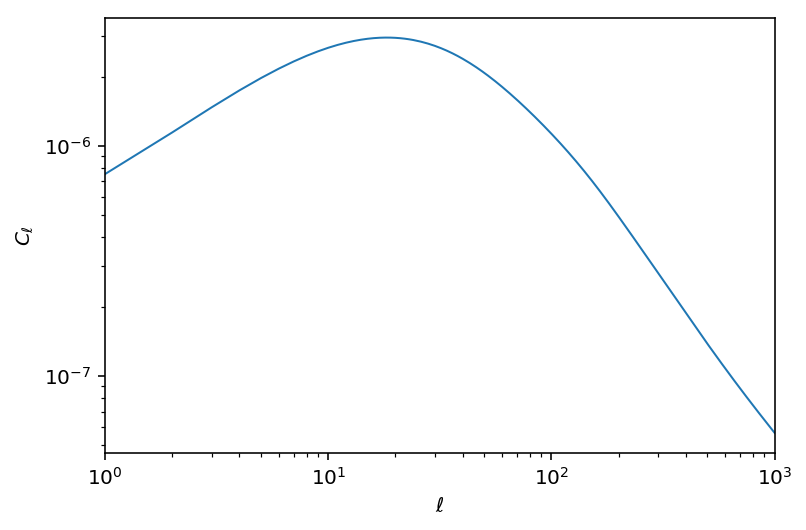

In [162]:
plt.loglog(ell, cls)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.xlim(1,lmax)

## Load the mask and completeness

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


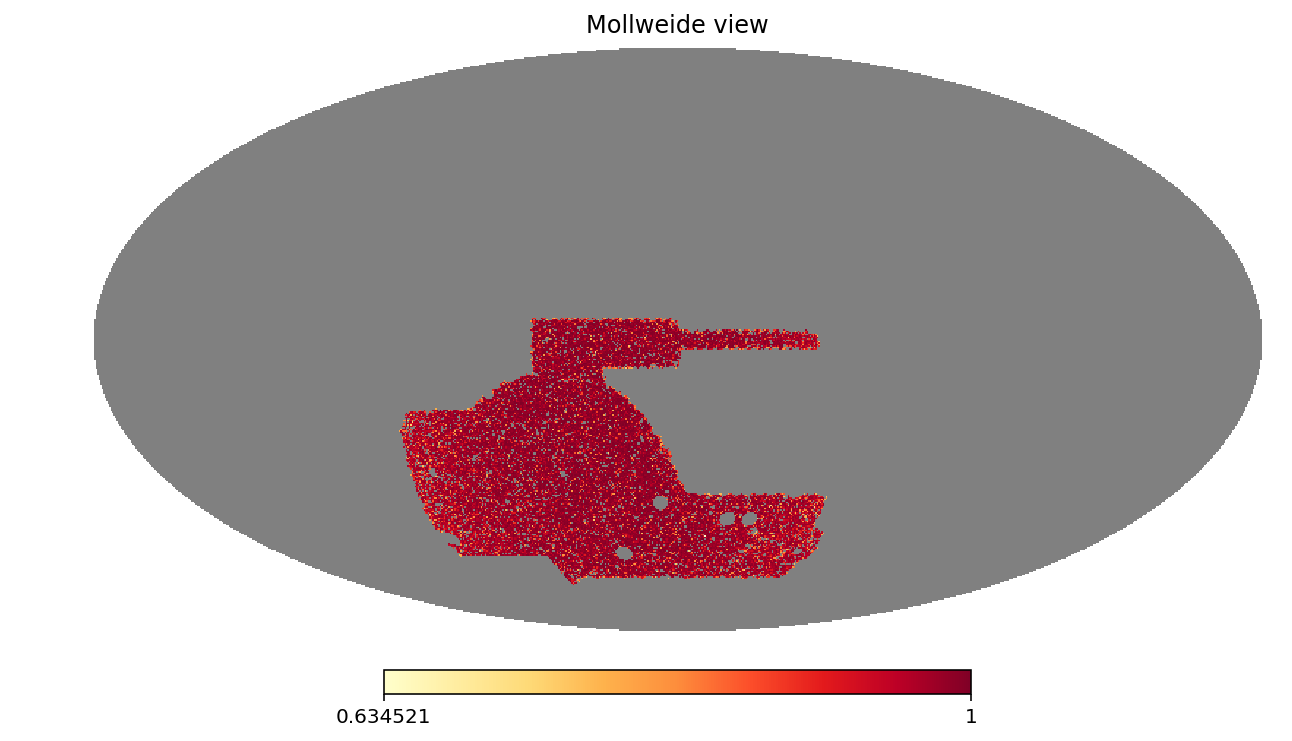

In [163]:
mask_frac = hp.read_map('y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_lgt20_vl02_FRACGOOD_nside512.fits')
hp.mollview(mask_frac, cmap=cmap)

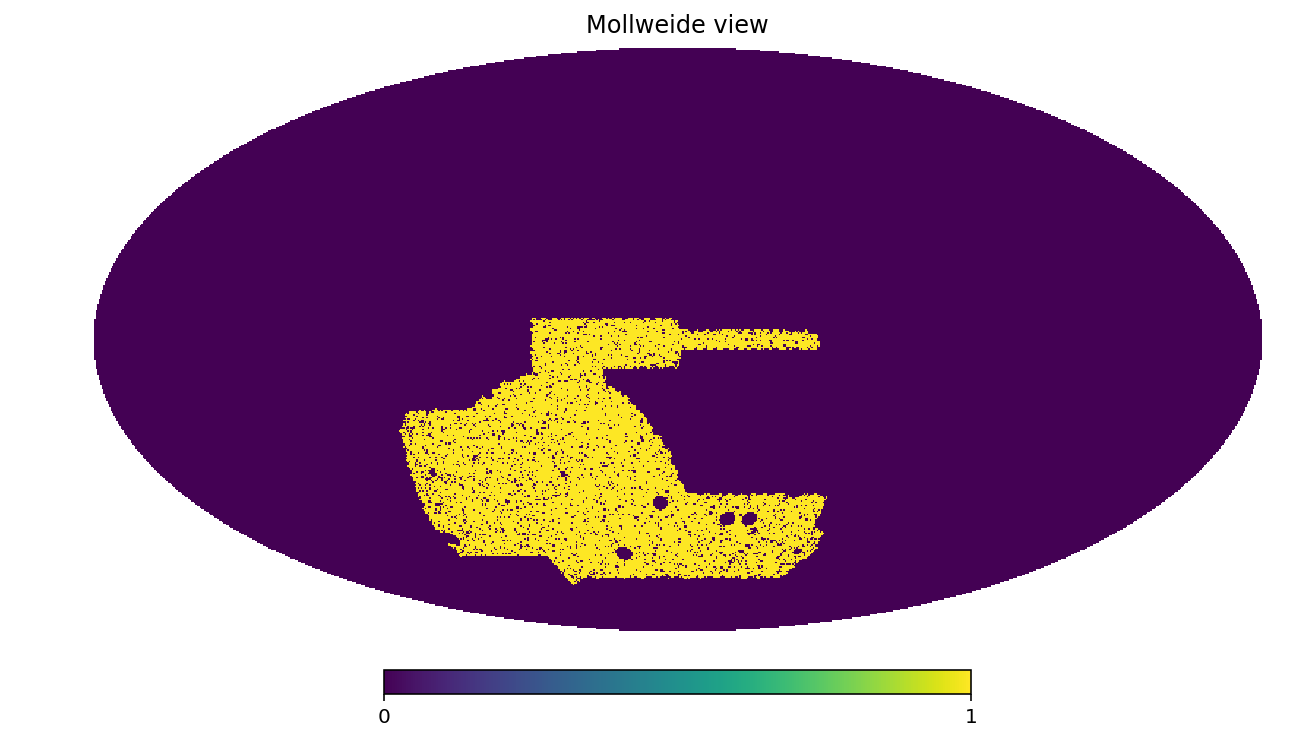

In [165]:
mask = (mask_frac > 0.)
hp.mollview(mask)

## Apodize the binary mask

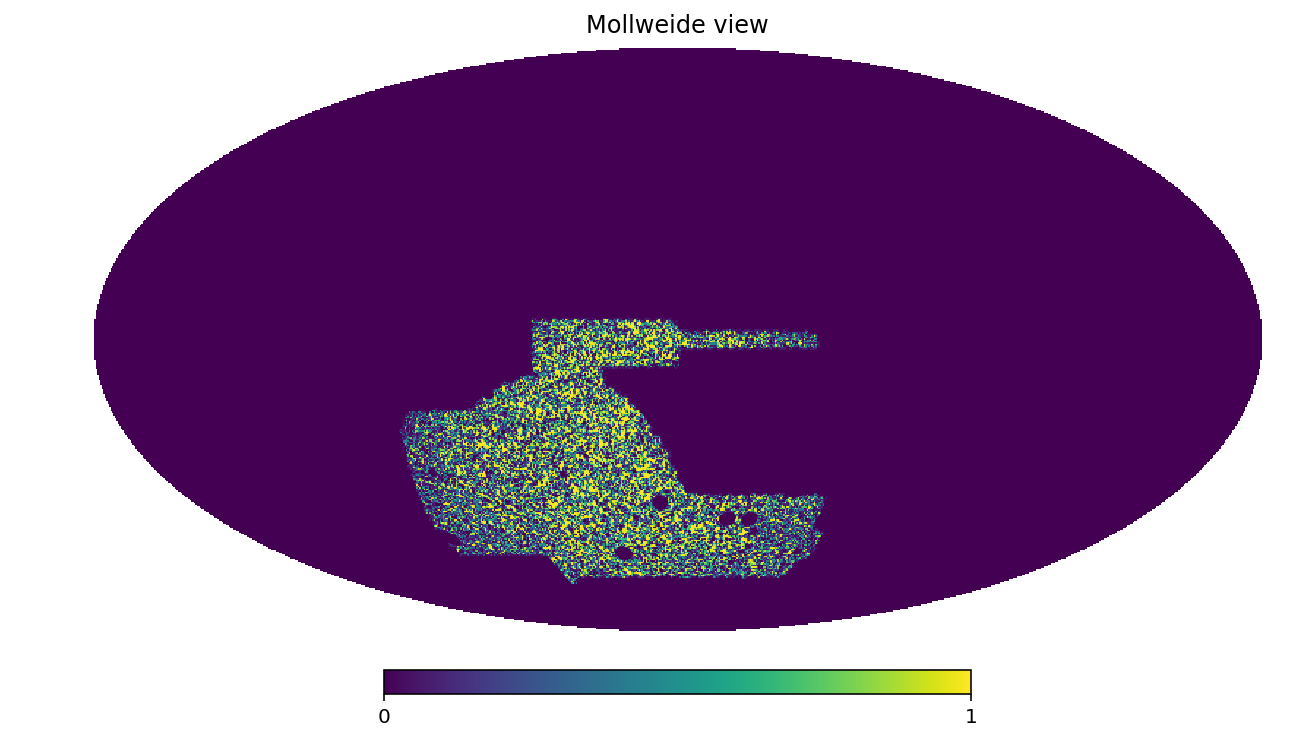

In [166]:
mask_apo = nmt.mask_apodization(mask, aposize=0.5, apotype='C1')
hp.mollview(mask_apo)

## Generate density map
1. Generate full sky density and mask it
1. Generate a count map by Poisson sampling (accounting for completeness)
1. Reconstruct a density map (idem)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


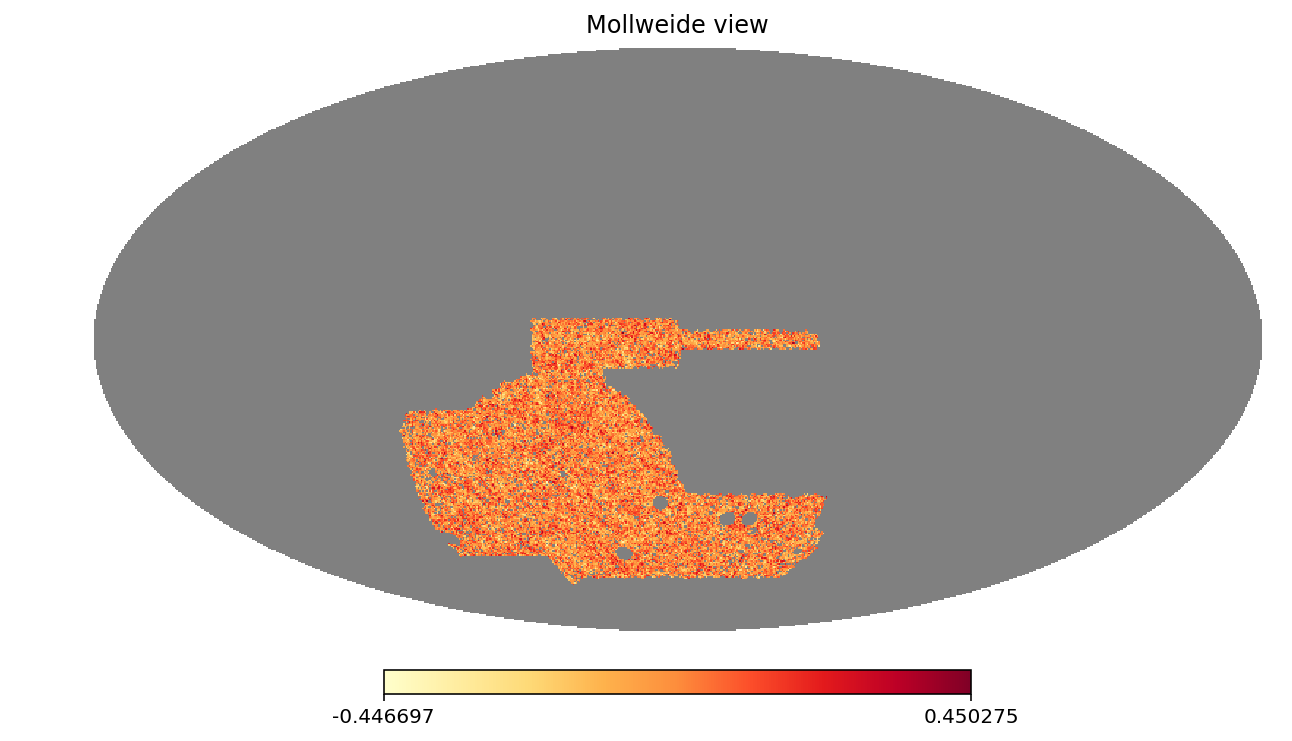

In [167]:
density_in = hp.synfast(cls, nside, lmax=lmax)
density_in[np.logical_not(mask)] = hp.UNSEEN
hp.mollview(density_in, cmap=cmap)

In [168]:
count = xgal.deltag.density2count(density_in, nbar, mask=mask, completeness=mask_frac, pixel=True)
print np.sum(count)

32718750


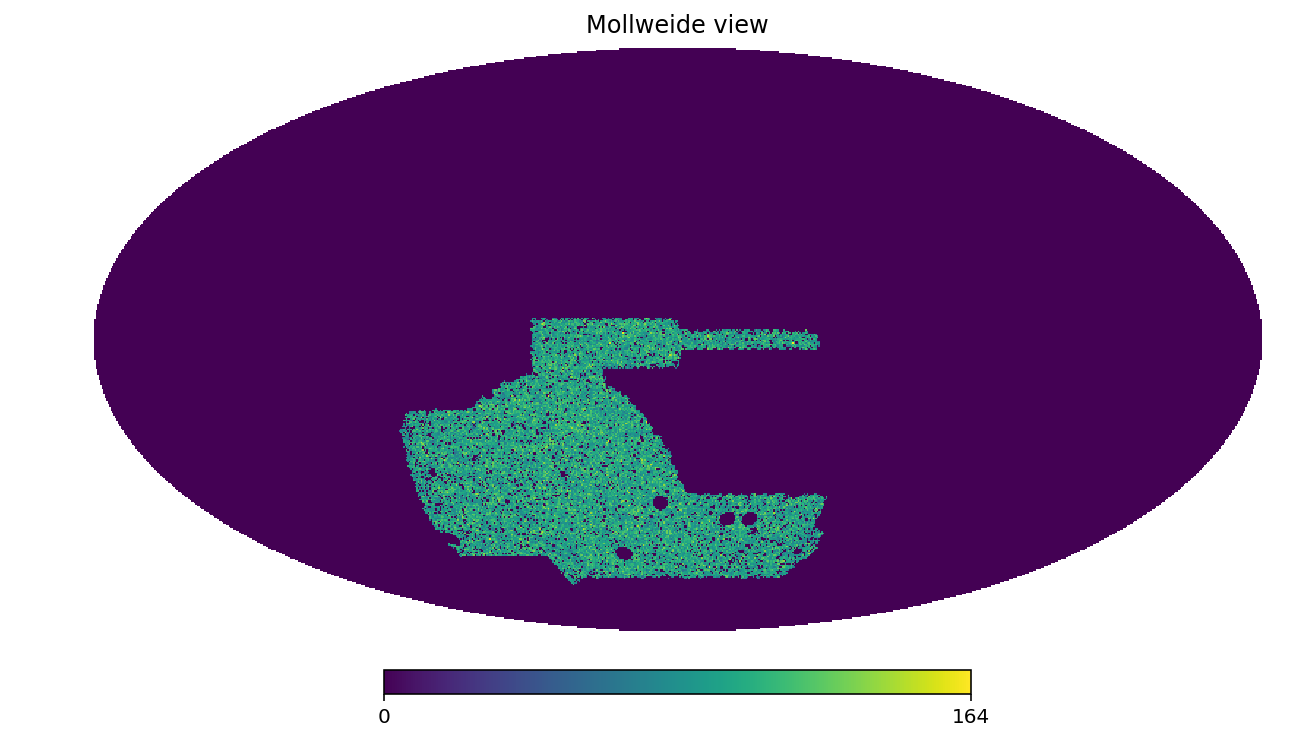

In [169]:
hp.mollview(count)

In [170]:
density_out = xgal.deltag.count2density(count, mask_frac=mask_frac, mask=mask)
density_out[np.logical_not(mask)] = hp.UNSEEN

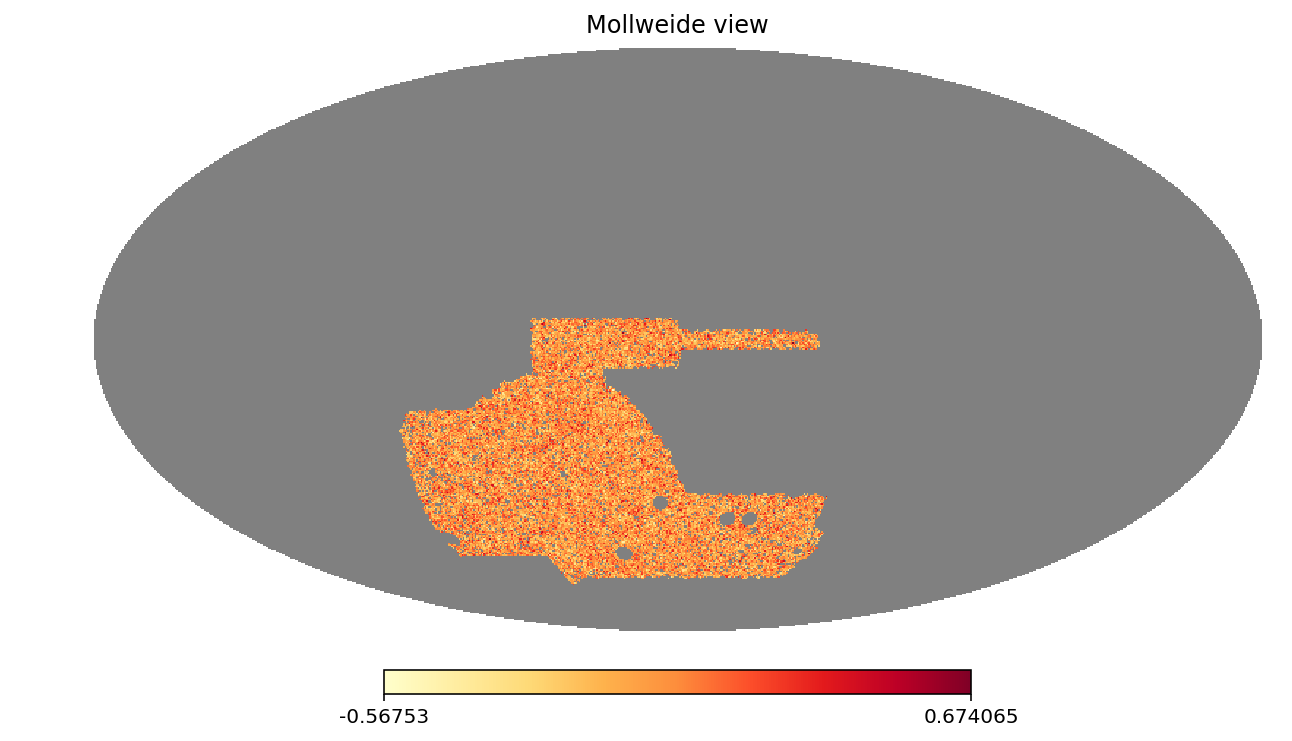

In [171]:
hp.mollview(density_out, cmap=cmap)

## Measure power spectra

In [174]:
field_in = nmt.NmtField(mask_apo, [density_in])

In [175]:
field_out = nmt.NmtField(mask_apo, [density_out])

In [176]:
b = nmt.NmtBin(nside, nlb=16, lmax=lmax)
ell_b = b.get_effective_ells()

In [190]:
# All maps have the same mask so use the same workspace
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field_in, field_in, b)

In [178]:
cls_test = []
cls_test.append(nmt.compute_full_master(field_in, field_in, b, workspace=wsp))
cls_test.append(nmt.compute_full_master(field_in, field_out, b, workspace=wsp))
cls_test.append(nmt.compute_full_master(field_out, field_out, b, workspace=wsp))
cls_test = np.array(cls_test)
cls_test = cls_test[:,0,:]

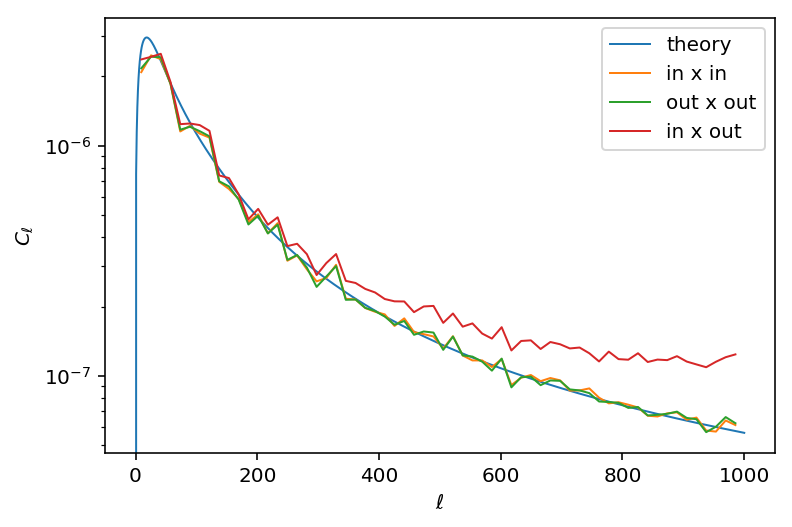

In [179]:
plt.plot(ell, cls, label='theory')
plt.plot(ell_b, cls_test[0], label='in x in')
plt.plot(ell_b, cls_test[1], label='out x out')
plt.plot(ell_b, cls_test[2], label='in x out')
plt.legend()
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.yscale('log')

## Generate 100 density maps to evaluate potential biases

In [180]:
def doit():
    density_in = hp.synfast(cls, nside, lmax=lmax, verbose=False)
    density_in[np.logical_not(mask)] = hp.UNSEEN
    
    count = xgal.deltag.density2count(density_in, nbar, mask=mask, completeness=mask_frac, pixel=True)
    
    density_out = xgal.deltag.count2density(count, mask_frac=mask_frac, mask=mask)
    density_out[np.logical_not(mask)] = hp.UNSEEN
    
    # Generate randoms to remove noise bias (could also be done by shuffling positions)
    random = xgal.deltag.density2count(np.zeros_like(density_in), nbar, mask=mask, pixel=True)
    random_density = xgal.deltag.count2density(random, mask_frac=None, mask=mask)
    
    field_in = nmt.NmtField(mask_apo, [density_in])
    field_out = nmt.NmtField(mask_apo, [density_out])
    field_r = nmt.NmtField(mask_apo, [random_density])
    
    cls_test = []
    cls_test.append(nmt.compute_full_master(field_in, field_in, b, workspace=wsp))
    cls_test.append(nmt.compute_full_master(field_in, field_out, b, workspace=wsp))
    cls_test.append(nmt.compute_full_master(field_out, field_out, b, workspace=wsp))
    cls_test.append(nmt.compute_full_master(field_r, field_r, b, workspace=wsp))
    cls_test = np.array(cls_test)
    cls_test = cls_test[:,0,:]
    
    return cls_test
    

In [181]:
cls_test = []
for i in tqdm.trange(100):
    cls_test.append(doit())
cls_test = np.array(cls_test)
cls_test[:,2,:] -= np.mean(cls_test[:,3,:],axis=0) #remove 

100%|██████████| 100/100 [12:47<00:00,  7.58s/it]


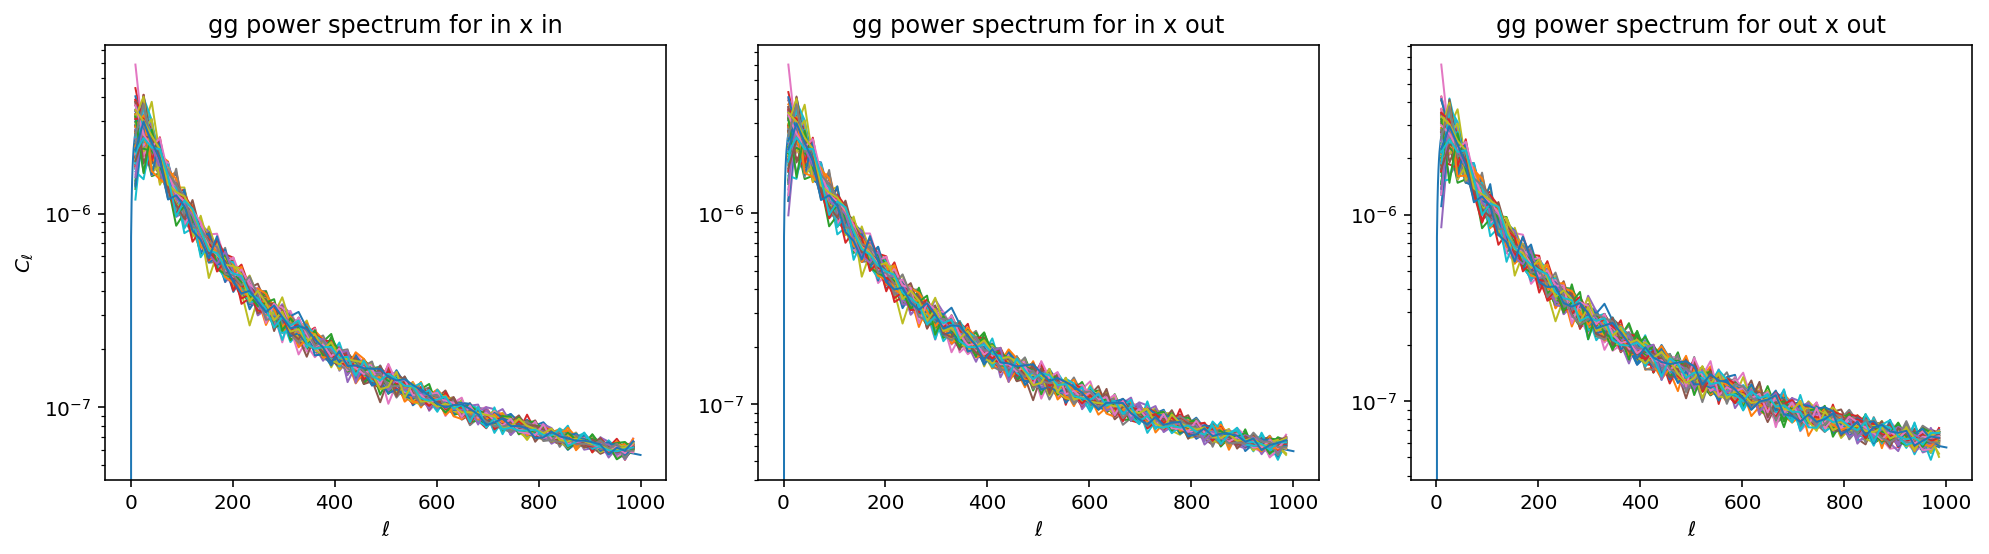

In [196]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
labels = ['in x in', 'in x out', 'out x out']
for i in range(3):
    ax = axes[i]
    ax.plot(ell, cls, label='input')
    for j in range(cls_test.shape[0]):
        ax.plot(ell_b, cls_test[j,i,:])
    ax.set_yscale('log')
    ax.set_title('gg power spectrum for %s'%labels[i])
    ax.set_xlabel('$\\ell$')
axes[0].set_ylabel('$C_\\ell$')
plt.tight_layout()

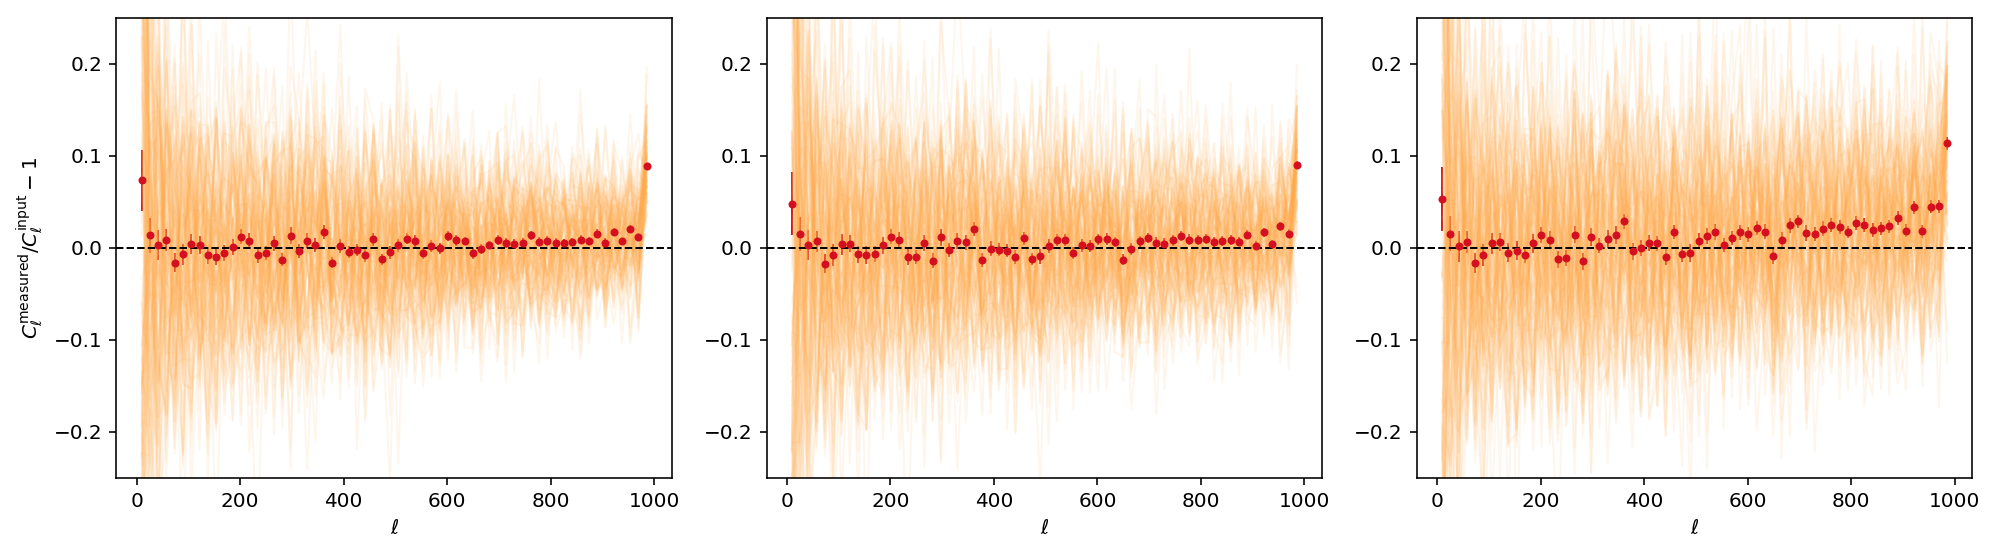

In [201]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
cls_in = b.bin_cell(cls)
for i in range(3):
    ax = axes[i]
#     ax.plot(ell, cls)
    for j in range(cls_test.shape[0]):
        ax.plot(ell_b, cls_test[j,i,:]/cls_in-1., c=mpl.cm.YlOrRd(0.4), alpha=0.1)
#     ax.set_yscale('log')
    m = (cls_test[:,i,:]/cls_in-1.).mean(axis=0)
    s = (cls_test[:,i,:]/cls_in-1.).std(axis=0) / np.sqrt(cls_test.shape[0])
    #ax.plot(ell_b, m, c=mpl.cm.YlOrRd(0.8))
    #ax.plot(ell_b, m-s, c=mpl.cm.YlOrRd(0.8), ls='--')
    #ax.plot(ell_b, m+s, c=mpl.cm.YlOrRd(0.8), ls='--')
    ax.errorbar(ell_b, m, s, color=mpl.cm.YlOrRd(0.8), ls=' ', marker='o', markersize=3)
    ax.set_ylim(-.25,+.25)
    ax.axhline(y=0., c='k', ls='--')
    ax.set_xlabel('$\\ell$')
axes[0].set_ylabel('$C_\\ell^{\\rm measured} / C_\\ell^{\\rm input} - 1$')
plt.tight_layout()